In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchtext
import torchtext.transforms as T
from torch.utils.data import DataLoader
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_num_workers
from torchlake.common.utils.text import (build_vocab, get_context,
                                         get_unigram_counts, is_corpus_title,
                                         is_longer_text)
from torchtext.data.utils import get_tokenizer
from torchlake.common.utils.platform import get_file_size
from torchlake.representation.models.ppmi.helper import CoOccurrenceCounter
from torchlake.representation.models import PPMI
from torchtext.datasets import WikiText2, WikiText103
from torchlake.common.utils.sparse import get_sparsity
from tqdm import tqdm

To utilize this notebook, you have to install `portalocker` first

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [4]:
DATASET_NAME = "WikiText103"

In [5]:
artifact_path = Path('../../artifacts/ppmi')
artifact_dataset_path = artifact_path / DATASET_NAME
data_path = Path('../../data') / DATASET_NAME

In [6]:
CONTEXT = NlpContext(device="cuda:0")

In [7]:
BATCH_SIZE = 32
CONTEXT_SIZE = 5

In [8]:
DEVICE = torch.device(CONTEXT.device)

In [9]:
tokenizer = get_tokenizer('basic_english')

In [10]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, context_size))
        .filter(lambda text: not is_corpus_title(text))
        .map(tokenizer)
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [11]:
train_datapipe, val_datapipe, test_datapipe = WikiText103(data_path.as_posix())

In [12]:
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
vocab = build_vocab(cloned_train_datapipe)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

166565

In [14]:
# write_json_file(
#     artifact_dataset_path.joinpath("vocab.json"),
#     list(vocab.get_stoi().keys()),
# )

In [15]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 's',
 'on',
 'as',
 'for',
 'that']

In [16]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.Truncate(CONTEXT.max_seq_len - 1),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [17]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [18]:
NUM_WORKERS = get_num_workers()

In [19]:
collate_fn = lambda data: get_context(
    data,
    CONTEXT_SIZE // 2,
    CONTEXT_SIZE // 2,
    flatten_output=True,
)

train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [20]:
# check context size
# for data in train_datapipe:
#     if len(data) < 5:
#         print(data)
#         break

In [21]:
# sample
# for data in train_datapipe:
#     if len(data) > 5:
#         print(data)
#         print(vocab.lookup_tokens(data))
#         break

In [22]:
# count = 0
# for data in train_datapipe:
#   count += len(data)
# count

In [23]:
# number of words in training corpurs
# wikitext2 count 1,993,228
# wikitext103 count 101,227,641

In [24]:
for gram, context in train_dataloader:
    print(gram.shape, context.shape)
    break

torch.Size([8064, 1]) torch.Size([8064, 4])


# training


In [25]:
# 4s ~ 5s with wikitext2
# 3m50s ~ 4m30s with wikitext103
word_counts = get_unigram_counts(map(lambda x: x.tolist(), train_datapipe), VOCAB_SIZE).to(DEVICE)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [26]:
sum(word_counts)

tensor(219471104, device='cuda:0')

In [25]:
counter = CoOccurrenceCounter(VOCAB_SIZE, padding_idx=CONTEXT.padding_idx)

# 8.6s co-occcurrence with wikitext2
# 9m3s co-occcurrence with wikitext103
for gram, context in tqdm(train_dataloader):
    counter.update_counts(gram, context)

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
26791it [08:54, 50.16it/s]


In [26]:
for (g, c), count in counter.counts.items():
    if count > 1:
        print(g, c, count)
        break

85 1 534


In [27]:
for (g, c), count in counter.counts.most_common()[-20:]:
    print(f"\"{vocab.lookup_token(g)}\" showed up with \"{vocab.lookup_token(c % VOCAB_SIZE)}\" on {c // VOCAB_SIZE} position {count} times")

"bungie" showed up with "news" on 2 position 1 times
"news" showed up with "bungie" on 1 position 1 times
"studio" showed up with "smith" on 3 position 1 times
"smith" showed up with "studio" on 0 position 1 times
"title" showed up with "bungie" on 3 position 1 times
"bungie" showed up with "title" on 0 position 1 times
"bungie" showed up with "manager" on 3 position 1 times
"manager" showed up with "bungie" on 0 position 1 times
"recent" showed up with "products" on 2 position 1 times
"products" showed up with "recent" on 1 position 1 times
"odst" showed up with "smith" on 3 position 1 times
"smith" showed up with "odst" on 0 position 1 times
"writers" showed up with "turned" on 3 position 1 times
"turned" showed up with "writers" on 0 position 1 times
"player" showed up with "investment" on 2 position 1 times
"investment" showed up with "player" on 1 position 1 times
"investment" showed up with "halo" on 3 position 1 times
"halo" showed up with "investment" on 0 position 1 times
"lea

In [31]:
model = PPMI(VOCAB_SIZE, CONTEXT_SIZE).to(DEVICE)

In [32]:
# 2m with wikitext2
# 36m with wikitext103

model.fit(counter, word_counts)

100%|██████████| 50472924/50472924 [37:21<00:00, 22513.10it/s] 


In [37]:
model.embedding.shape

d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\language_model\models\ppmi\model.py:31: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  ).to_sparse_csr(),


torch.Size([166565, 666260])

In [38]:
get_sparsity(model.embedding)

0.9995451889837954

In [39]:
model.transform(next(iter(train_datapipe)))

tensor(indices=tensor([[     1,      1,      1,  ...,    124,    124,    124],
                       [     6,     15,     30,  ..., 332938, 333133, 499698]]),
       values=tensor([3.2353, 5.3732, 6.1751,  ..., 5.7559, 8.0778, 7.0816]),
       size=(256, 666260), nnz=13808964, layout=torch.sparse_coo)

# Visualization

In [40]:
encoded_dims = [row._nnz() for row in model.embedding]

(0.0, 1000.0)

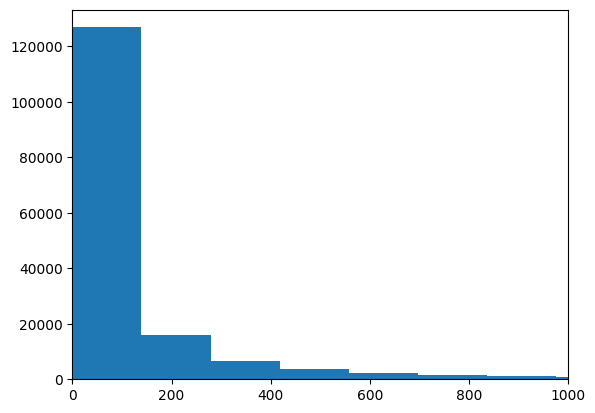

In [41]:
plt.hist(encoded_dims, bins=3000)
plt.xlim(0, 1000)

In [42]:
import numpy as np

In [43]:
encoded_dims = np.array(encoded_dims)

print("mean dim:", encoded_dims.mean())
print("median dim:", np.median(encoded_dims))
print("max dim:", encoded_dims.max())
print("min dim:", encoded_dims[encoded_dims != 0].min())
print("# of zero dim:", sum(encoded_dims == 0)) # about 3rd of vocab is not center word or too small PPMI

mean dim: 303.02238765647047
median dim: 44.0
max dim: 418161
min dim: 4
# of zero dim: 34


# Save & Load

In [33]:
model_path = artifact_path / f"ppmi.{DATASET_NAME}.pth"

In [34]:
import joblib

In [35]:
joblib.dump(model, model_path)

['..\\..\\artifacts\\ppmi\\ppmi.WikiText103.pth']

In [36]:
get_file_size(model_path)

'783.27MB'

In [85]:
model = joblib.load(model_path)

# Evaluation


## word analogy


In [44]:
from torchlake.language_model.datasets import WordAnalogyDataset 

In [45]:
analogy_data_path = Path('../../data') / "word-analogy"

In [46]:
dataset = WordAnalogyDataset(analogy_data_path)

In [47]:
dataset.data[:20]

[('Athens', 'Greece', 'Baghdad', 'Iraq'),
 ('Athens', 'Greece', 'Bangkok', 'Thailand'),
 ('Athens', 'Greece', 'Beijing', 'China'),
 ('Athens', 'Greece', 'Berlin', 'Germany'),
 ('Athens', 'Greece', 'Bern', 'Switzerland'),
 ('Athens', 'Greece', 'Cairo', 'Egypt'),
 ('Athens', 'Greece', 'Canberra', 'Australia'),
 ('Athens', 'Greece', 'Hanoi', 'Vietnam'),
 ('Athens', 'Greece', 'Havana', 'Cuba'),
 ('Athens', 'Greece', 'Helsinki', 'Finland'),
 ('Athens', 'Greece', 'Islamabad', 'Pakistan'),
 ('Athens', 'Greece', 'Kabul', 'Afghanistan'),
 ('Athens', 'Greece', 'London', 'England'),
 ('Athens', 'Greece', 'Madrid', 'Spain'),
 ('Athens', 'Greece', 'Moscow', 'Russia'),
 ('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden')]

In [48]:
tokens = [tuple(vocab[word.lower()] for word in pairs) for pairs in dataset.data]
tokens[:10]

[(5230, 3353, 11394, 4009),
 (5230, 3353, 18669, 7724),
 (5230, 3353, 6118, 1092),
 (5230, 3353, 3196, 806),
 (5230, 3353, 20191, 3950),
 (5230, 3353, 9137, 2561),
 (5230, 3353, 7362, 436),
 (5230, 3353, 19365, 2408),
 (5230, 3353, 11409, 3881),
 (5230, 3353, 14788, 4553)]

In [49]:
vectors = torch.stack([model.transform(row) for row in tokens]).to(DEVICE)

In [50]:
country_a, capital_a, country_b, capital_b = vectors[:30]
vec_a, vec_b = country_a - capital_a - country_b, - capital_b
dot_product = sum(vec_a * vec_b)
dot_product = dot_product / vec_a.square().sum().sqrt() / vec_b.square().sum().sqrt()
print(dot_product.mean().item())

0.0356750562787056
0.028615456074476242
0.05373813211917877
0.0428149588406086
0.04453866183757782
0.05186973512172699
0.04272329807281494
0.03736896812915802
0.03755047544836998
0.06245752424001694
0.03166994825005531
0.037349883466959
0.027663541957736015
0.04569718614220619
0.04730766639113426
0.048252005130052567
0.031539902091026306
0.04181956127285957
0.04781003296375275
0.035820893943309784
0.041760802268981934
0.037187084555625916
0.03641853109002113
0.046402666717767715
0.031017053872346878
0.028547421097755432
0.06719459593296051
0.03516729176044464
0.061513837426900864
0.0422431156039238
